In [30]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras import optimizers
from keras.layers.normalization import BatchNormalization

In [31]:
np.random.seed(7)
tf.set_random_seed(7)


In [32]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [33]:
train = pd.read_csv('UCI_HAR_Dataset/train/train.csv')
test = pd.read_csv('UCI_HAR_Dataset/test/test.csv')

X_train = train.drop(['subject', 'Activity'], axis=1)
Y_train = train.Activity


In [34]:
def get_data_train(data_type=None):
    
    data_path = "UCI_HAR_Dataset/"
    type_path = "{}/".format(data_type)
    
    input_data_path = data_path + type_path + '/*.csv'
    input_data_files = sorted(glob.glob(input_data_path))

    if not __debug__:
        print(input_data_files)

    x = np.dstack([X_train for input_data_file in input_data_files])
    y = y_one_hot = pd.get_dummies(Y_train).as_matrix()

    return x, y

def get_data_test(data_type=None):
    
    data_path = "UCI_HAR_Dataset/"
    type_path = "{}/".format(data_type)
    
    input_data_path = data_path + type_path + '/*.csv'
    input_data_files = sorted(glob.glob(input_data_path))

    if not __debug__:
        print(input_data_files)

    x = np.dstack([X_test for input_data_file in input_data_files])
    y = y_one_hot = pd.get_dummies(Y_test).as_matrix()

    return x, y

In [35]:
X_train, Y_train = get_data_train("train")

C:\Users\Master\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [36]:

X_test = test.drop(['subject', 'Activity'], axis=1)
Y_test = test.Activity

In [37]:
X_test, Y_test = get_data_test("test")

C:\Users\Master\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [38]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [39]:
from keras import backend as keras_backend
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras_backend.set_session(sess)

In [40]:
# Initializing parameters
epochs = 45
batch_size = 64
n_hidden = 32

In [41]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [42]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))


561
1
7352


### LSTM Architecture - 1

In [43]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 606       
Total params: 8,258
Trainable params: 8,258
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [45]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/45
7352/7352 [==============================] - 119s 16ms/step - loss: 1.5635 - acc: 0.2806 - val_loss: 1.2866 - val_acc: 0.3495
Epoch 2/45
7352/7352 [==============================] - 108s 15ms/step - loss: 1.3321 - acc: 0.3347 - val_loss: 1.1674 - val_acc: 0.3495
Epoch 3/45
7352/7352 [==============================] - 99s 13ms/step - loss: 1.2442 - acc: 0.3453 - val_loss: 1.1114 - val_acc: 0.3383
Epoch 4/45
7352/7352 [==============================] - 86s 12ms/step - loss: 1.1769 - acc: 0.3555 - val_loss: 1.1044 - val_acc: 0.3509
Epoch 5/45
7352/7352 [==============================] - 81s 11ms/step - loss: 1.1678 - acc: 0.3520 - val_loss: 1.1184 - val_acc: 0.3482
Epoch 6/45
7352/7352 [==============================] - 82s 11ms/step - loss: 1.1467 - acc: 0.3645 - val_loss: 1.1188 - val_acc: 0.3495
Epoch 7/45
7352/7352 [==============================] - 88s 12ms/step - loss: 1.1364 - acc: 0.3613 - val_loss: 1.2254 - val_acc: 0.334

In [46]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 352      108         8        1                   2   
SITTING                 20      469         7        0                   0   
STANDING                53      118       249        0                   0   
WALKING                  0        0         0      536                   0   
WALKING_DOWNSTAIRS       0        0         0        0                 454   
WALKING_UPSTAIRS         0        0         0       11                  73   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            1  
WALKING_DOWNSTAIRS                78  
WALKING_UPSTAIRS                 407  


In [47]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 9s 3ms/step


In [48]:
score

[0.4310899884125561, 0.8371224974651518]

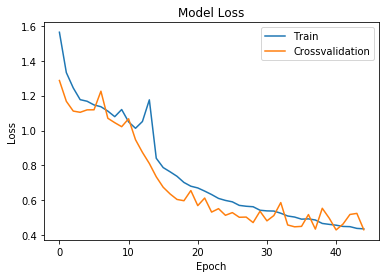

In [49]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'])

### LSTM Architecture - 2

In [50]:
# Initiliazing the sequential model
model_2 = Sequential()
# Configuring the parameters
model_2.add(LSTM(32, return_sequences = True, input_shape=(timesteps, input_dim)))
model_2.add(Dropout(0.4))
model_2.add(LSTM(32))
model_2.add(Dropout(0.4))
model_2.add(Dense(100, activation='relu'))
# Adding a dense output layer with sigmoid activation
model_2.add(Dense(n_classes, activation='sigmoid'))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 561, 32)           4352      
_________________________________________________________________
dropout_8 (Dropout)          (None, 561, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 606       
Total params: 16,578
Trainable params: 16,578
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compiling the model
model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [52]:
# Training the model
model_2.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/45
7352/7352 [==============================] - 198s 27ms/step - loss: 1.4336 - acc: 0.3112 - val_loss: 1.1465 - val_acc: 0.3502
Epoch 2/45
7352/7352 [==============================] - 193s 26ms/step - loss: 1.1877 - acc: 0.3475 - val_loss: 1.1170 - val_acc: 0.3492
Epoch 3/45
7352/7352 [==============================] - 206s 28ms/step - loss: 1.1553 - acc: 0.3477 - val_loss: 1.1119 - val_acc: 0.3495
Epoch 4/45
7352/7352 [==============================] - 210s 28ms/step - loss: 1.1497 - acc: 0.3527 - val_loss: 1.1752 - val_acc: 0.3431
Epoch 5/45
7352/7352 [==============================] - 204s 28ms/step - loss: 1.1402 - acc: 0.3534 - val_loss: 1.1044 - val_acc: 0.3539
Epoch 6/45
7352/7352 [==============================] - 224s 30ms/step - loss: 1.1349 - acc: 0.3566 - val_loss: 1.2340 - val_acc: 0.3295
Epoch 7/45
7352/7352 [==============================] - 197s 27ms/step - loss: 1.1037 - acc: 0.3745 - val_loss: 1.0551 - val_acc: 

In [53]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_2.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 387       26        54        0                   4   
SITTING                 91      352        53        0                   0   
STANDING                43        7       370        0                   0   
WALKING                  0        1         0      529                   7   
WALKING_DOWNSTAIRS       6        2         0        1                 499   
WALKING_UPSTAIRS         1        0         0       20                 215   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                24  
WALKING_UPSTAIRS                 255  


In [54]:
score = model_2.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 19s 7ms/step


[0.4960798446732454, 0.8116728876823889]

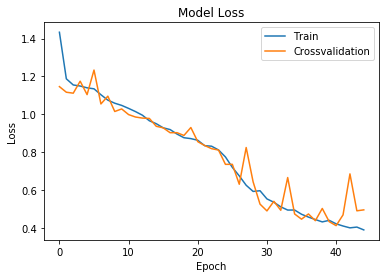

In [55]:
plt.plot(model_2.history.history['loss'])
plt.plot(model_2.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'])

### LSTM Architecture - 3

In [56]:
# Initiliazing the sequential model
model_3 = Sequential()
# Configuring the parameters
model_3.add(LSTM(32, return_sequences = True, input_shape=(timesteps, input_dim)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.4))
model_3.add(LSTM(32, return_sequences=True))

model_3.add(Dropout(0.3))
model_3.add(LSTM(32, return_sequences= False))

model_3.add(BatchNormalization())
model_3.add(Dropout(0.4))
model_3.add(Dense(100, activation='relu'))
# Adding a dense output layer with sigmoid activation
model_3.add(Dense(n_classes, activation='sigmoid'))
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 561, 32)           4352      
_________________________________________________________________
batch_normalization_3 (Batch (None, 561, 32)           128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 561, 32)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 561, 32)           8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 561, 32)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
__________

In [57]:
# Compiling the model
model_3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [58]:
# Training the model
model_3.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/45
7352/7352 [==============================] - 358s 49ms/step - loss: 1.1650 - acc: 0.3938 - val_loss: 1.0511 - val_acc: 0.4449
Epoch 2/45
7352/7352 [==============================] - 357s 49ms/step - loss: 1.0506 - acc: 0.4631 - val_loss: 3.1254 - val_acc: 0.2409
Epoch 3/45
7352/7352 [==============================] - 358s 49ms/step - loss: 0.9734 - acc: 0.5303 - val_loss: 0.9797 - val_acc: 0.5348
Epoch 4/45
7352/7352 [==============================] - 357s 49ms/step - loss: 0.9263 - acc: 0.5691 - val_loss: 1.1366 - val_acc: 0.5253
Epoch 5/45
7352/7352 [==============================] - 353s 48ms/step - loss: 0.8373 - acc: 0.6192 - val_loss: 0.9292 - val_acc: 0.6210
Epoch 6/45
7352/7352 [==============================] - 354s 48ms/step - loss: 0.7117 - acc: 0.6859 - val_loss: 0.6972 - val_acc: 0.7224
Epoch 7/45
7352/7352 [==============================] - 357s 49ms/step - loss: 0.6067 - acc: 0.7361 - val_loss: 0.5349 - val_acc: 

In [59]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_3.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 439       24         8        0                   0   
SITTING                 37      447        12        0                   0   
STANDING                48        2       370        0                   0   
WALKING                  1        0         0      536                   0   
WALKING_DOWNSTAIRS       1        1         0        0                 486   
WALKING_UPSTAIRS         3        0         0        2                 130   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                44  
WALKING_UPSTAIRS                 356  


In [60]:
score = model_3.evaluate(X_test, Y_test)
score

2947/2947 [==============================] - 26s 9ms/step


[0.2705098457803838, 0.8937902952154734]

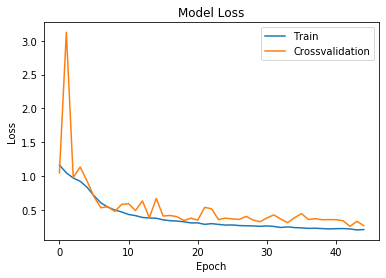

In [61]:
plt.plot(model_3.history.history['loss'])
plt.plot(model_3.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'])